In [60]:
import numpy as np
import pandas as pd
import requests
from requests.exceptions import HTTPError
import pickle
from datetime import datetime, timedelta, date
import time
import matplotlib.pyplot as plt
from IPython.display import display
import traceback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score,f1_score,make_scorer
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from joblib import dump, load
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, GridSearchCV

In [36]:
ROOT_PATH = './JakartaTrainingData'

## Get weather data from TWC API

In [37]:
def request_historical_data(year):
    TWC_APIKEY=''
    url = 'https://api.weather.com/v3/wx/hod/reanalysis/historical/point?pointType=nearest&key={lat},{lon}&startDateTime={start_dt}&endDateTime={end_dt}&units=m&format=json&apiKey={TWC_APIKEY}'
    hist_weather = {'dewpoint': [],
                'latitude': [],
                'longitude': [],
                'observationTimeUtcIso': [],
                'precipitationRate': [],
                'pressure': [],
                'relativeHumidity': [],
                'temperature': [],
                'windDirection': [],
                'windSpeed': []}

    # quarterly time periods to loop over
    if year == 2014:
        time_periods = [(f'{year}10010100', f'{year}12312300')] # this is the limit of HoD data
    else:
        time_periods = [
                        (f'{year}01010000', f'{year}02010000'),
                        # (f'{year}01010000', f'{year}04010000'),
                        # (f'{year}04010000', f'{year}07010000'),
                        # (f'{year}07010000', f'{year}10010000'),
                        # (f'{year}10010000', f'{year}12312300'),  
        ]

    for period in time_periods:
        start, end = period[0], period[1]
        try:
            r = requests.get(url.format(lat = '-6.181727421364025', lon = '106.81394894687006', start_dt=start, end_dt=end, TWC_APIKEY=TWC_APIKEY))
            r.raise_for_status()
            data = r.json()
            for key, value in data.items():
                hist_weather[key] += value
        except HTTPError as http_err:
            print(f'HTTP error occurred: {http_err}')  
        time.sleep(5)
    return hist_weather

if False:
    year = 2021
    hist_weather = request_historical_data(year)
    hist_weather = pd.DataFrame(hist_weather)
    hist_weather.to_csv(f'./hist-weather({year}).csv')

## Load and format data

In [38]:
# Helper functions

def format_hist_df(df, start, end):
    start = f'{start}-10-01' if start == 2014 else f'{start}-01-01'
    end = f'{end}-01-01'
    df['Date'] = pd.to_datetime(df['Date'], errors='raise')
    df.drop_duplicates(inplace=True)
    df = df[(df['Date'] > start) & (df['Date'] < end)]
    def extend_timerange(df):
        temp_df = df.copy()
        extend_by = 0
        for index, row in temp_df.iterrows():
            # for days in range(1,4):
            additional_df = pd.DataFrame(
                {'Location': ['Jakarta' for _ in range(1,extend_by+1)], 
                 'Date': [row.Date - timedelta(days=day) for day in range(1,extend_by+1)]}
            )
            df = pd.concat([df, additional_df], ignore_index=True)
                # df = df.append({'Location': row.Location, 'Date': row.Date - timedelta(days=days)}, ignore_index=True)
        return df                 
        
    df['Date'] = df['Date'].dt.date

    return df

def date_encode(df, col, max_val):
    df[col + 'Sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + 'Cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

In [39]:
start_year = 2018
end_year = 2021

In [40]:
# Load and format hist_weather
frames = []
for year in range(start_year, end_year+1):
    frames.append(pd.read_csv(f'{ROOT_PATH}/csvs/hist-weather({year}).csv', index_col=0))
hist_weather = pd.concat(frames, ignore_index=True)
hist_weather.rename(columns={'observationTimeUtcIso': 'Date'}, inplace=True)
hist_weather = format_hist_df(hist_weather, start_year, end_year+1)
hist_weather = hist_weather.groupby([hist_weather['Date']]).sum().reset_index() # sum daily values
hist_weather['year'] = pd.DatetimeIndex(hist_weather['Date']).year.astype(int)
hist_weather['month'] = pd.DatetimeIndex(hist_weather['Date']).month # will be dropped
hist_weather['day'] = pd.DatetimeIndex(hist_weather['Date']).day # will be dropped
hist_weather = date_encode(hist_weather, 'month', 12)
hist_weather = date_encode(hist_weather, 'day', 30)
hist_weather.drop(['month', 'day'], axis=1, inplace=True)
hist_weather['past7dayPrecipitationRate'] = hist_weather['precipitationRate'].rolling(min_periods=1, window=7).sum()
hist_weather['centred7dayPrecipitationRate'] = hist_weather['precipitationRate'].rolling(min_periods=1, window=7, center=True).sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
hist_twitter = pd.read_csv(f'{ROOT_PATH}/csvs/hist_twitter.csv')
hist_twitter = format_hist_df(hist_twitter[['Location', 'Date']], start_year, end_year+1)
display(hist_twitter['Date'].astype(str).str[:4].value_counts())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2020    23
2018    14
2019    14
2021     4
Name: Date, dtype: int64

In [42]:
hist_twitter_verified = pd.read_csv(f'{ROOT_PATH}/csvs/hist_twitter(2014-2018 verified).csv')
hist_twitter_verified = format_hist_df(hist_twitter_verified[['Location', 'Date']], start_year, end_year+1)
display(hist_twitter_verified['Date'].astype(str).str[:4].value_counts())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018    6
Name: Date, dtype: int64

In [43]:
hist_posKota = pd.read_csv(f'{ROOT_PATH}/csvs/hist_posKota.csv')
hist_posKota = format_hist_df(hist_posKota[['Location', 'Date']], start_year, end_year+1)
display(hist_posKota['Date'].astype(str).str[:4].value_counts())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

2019    40
2018    39
2020     1
Name: Date, dtype: int64

In [44]:
hist_floods = pd.read_csv(f'{ROOT_PATH}/csvs/data-combined.csv')
hist_floods = format_hist_df(hist_floods, start_year, end_year+1) # completely verified from Govt sources or news 
display(hist_floods['Date'].astype(str).str[:4].value_counts())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018    22
2019     2
Name: Date, dtype: int64

In [45]:
hist_opendata = pd.read_csv(f'{ROOT_PATH}/csvs/hist_opendata_2019.csv')
hist_opendata = format_hist_df(hist_opendata, start_year, end_year+1) # completely verified from Jakarta Open Data
display(hist_opendata['Date'].astype(str).str[:4].value_counts())

2019    23
Name: Date, dtype: int64

In [46]:
frames = []
for year in range(start_year, end_year+1):
    try:
        frames.append(pd.read_csv(f'{ROOT_PATH}/csvs/hist_news_{year}.csv', index_col=0))
    except FileNotFoundError as e:
        print("Warning, the following file was not found: ", f'{ROOT_PATH}/csvs/hist_news_{year}.csv')
hist_news = pd.concat(frames, ignore_index=True)
hist_news = format_hist_df(hist_news, start_year, end_year+1) 
display(hist_news['Date'].astype(str).str[:4].value_counts())

Warning, the following file was not found:  /content/drive/My Drive/Flood Guardian/csvs/hist_news_2018.csv


2020    79
2019    33
2021    10
Name: Date, dtype: int64

## Visualize data

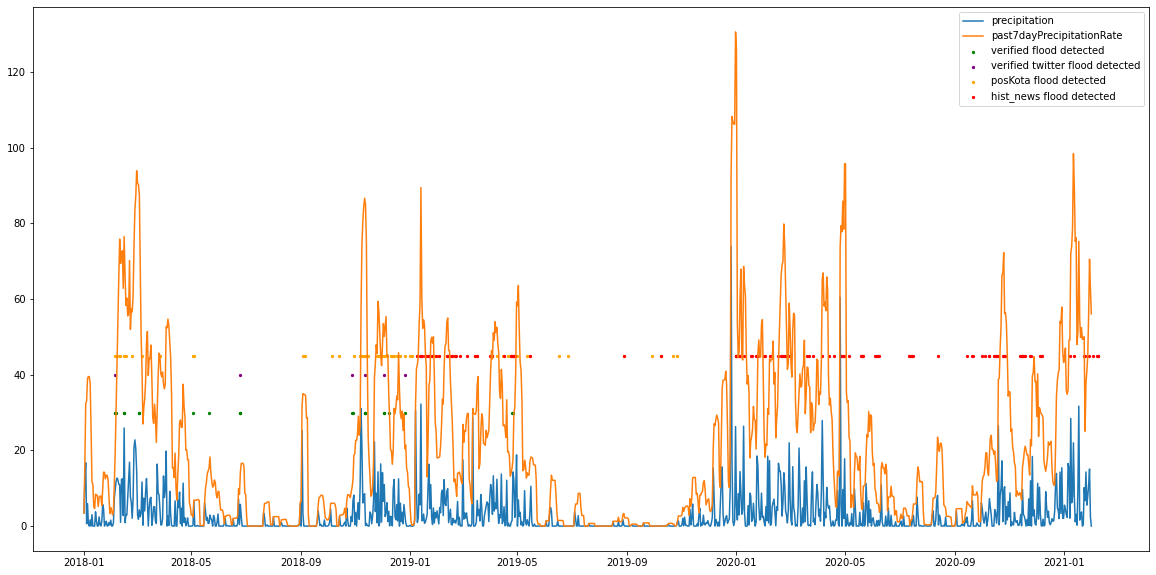

In [47]:
plt.figure(figsize=(20,10))
plt.plot(hist_weather['Date'], hist_weather['precipitationRate'], label='precipitation')
plt.plot(hist_weather['Date'], hist_weather['past7dayPrecipitationRate'], label='past7dayPrecipitationRate')

plt.scatter(hist_floods['Date'],[30 for _ in range(len(hist_floods))], color='green', s=5, label='verified flood detected')
plt.scatter(hist_twitter_verified['Date'],[40 for _ in range(len(hist_twitter_verified))], color='purple', s=5, label='verified twitter flood detected')
plt.scatter(hist_posKota['Date'],[45 for _ in range(len(hist_posKota))], color='orange', s=5, label='posKota flood detected')
plt.scatter(hist_news['Date'],[45 for _ in range(len(hist_news))], color='red', s=5, label='hist_news flood detected')
plt.legend()

## Preprocess data

#### Construct `data` 

In [48]:
# 'year' will be dropped during data split. For now it's just used to separate data
fts = [ 'year','relativeHumidity', 'precipitationRate', 'centred7dayPrecipitationRate', 'past7dayPrecipitationRate', 'monthSin', 'monthCos', 'daySin', 'dayCos']
data = hist_weather[fts]
data['flood'] = (
    hist_weather.Date.isin(hist_floods.Date)\
                 | hist_weather.Date.isin(hist_twitter_verified.Date)\
                 | hist_weather.Date.isin(hist_posKota.Date)\
                 | hist_weather.Date.isin(hist_opendata.Date)\
                 | hist_weather.Date.isin(hist_news.Date)\
).astype(int)   

0       2018
1       2018
2       2018
3       2018
4       2018
        ... 
1123    2021
1124    2021
1125    2021
1126    2021
1127    2021
Name: year, Length: 1128, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### Scale then split into training and validation sets

In [49]:
def split_data(data):
    X = data[fts]
    X.drop(['year'], inplace=True, axis=1)
    X = X.to_numpy()
    X = preprocessing.RobustScaler().fit_transform(X)

    y = data.flood
    y = y.to_numpy()
    return train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_test, y_train, y_test = split_data(data)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Handle imbalance

Perform SMOTE on training data

In [50]:
from sklearn.utils import resample
import imblearn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('SMOTE before: ',np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1))
sm = SMOTE(sampling_strategy=1, random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('SMOTE after: ',np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1))

SMOTE before:  793 165
SMOTE after:  793 793


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Recombine all data into a single `X_train`, `y_train`, `X_test`, and `y_test`

In [51]:
X_train = np.vstack((X_train))
y_train = np.hstack((y_train))
X_test = np.vstack((X_test))
y_test = np.hstack((y_test))

### Iterate over and evaluate list of classifiers

In [54]:
X = np.vstack((X_train, X_test))
y = np.concatenate((y_train, y_test))


classifiers = [
               DummyClassifier(strategy='stratified'),
               KNeighborsClassifier(n_neighbors=3), 
               KNeighborsClassifier(n_neighbors=5), 
               AdaBoostClassifier(), 
               GradientBoostingClassifier(), 
               SVC(kernel='linear', probability=True), 
               RandomForestClassifier(),
               ExtraTreesClassifier(),
               DecisionTreeClassifier(),
]
kf = KFold()
for clf in classifiers:
    curr_acc = 0
    curr_f1_score = 0
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index] 
    
        sm = SMOTE(sampling_strategy=1, random_state=42)
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        model = clf
        model.fit(X_train_oversampled, y_train_oversampled )  
        y_pred = model.predict(X_test)
        curr_acc += model.score(X_test, y_test)
        curr_f1_score += f1_score(y_test, y_pred)
    print(clf)
    print(f'Accuracy: {curr_acc/5}')
    print(f'f-score: {curr_f1_score/5}')
    print('====================================')

DummyClassifier(constant=None, random_state=None, strategy='stratified')
Accuracy: 0.5222173659673659
f-score: 0.41796966652423784
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Accuracy: 0.818932918932919
f-score: 0.7543511093965439
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Accuracy: 0.793312937062937
f-score: 0.7296346731224714
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Accuracy: 0.76995596995597
f-score: 0.6455550936953065
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_feature

### Perform hyperparamter tuning on ExtraTreesClassifier

{'n_estimators': 80}
0.8831908831908832
0.8972431077694234


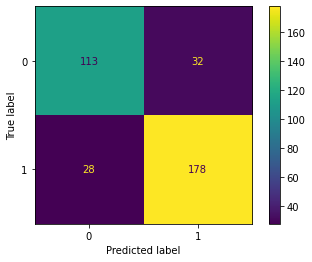

In [61]:
# params = {
#     "oob_score":[True, False],
#     "min_samples_split": np.linspace(0.1, 1, 10),
#     "min_samples_leaf": np.linspace(0.1, 1, 10),
#     "max_depth":[3,5,8],
#     "max_features":["log2","sqrt"],
#     "criterion": ["gini",  "entropy"],
#     "n_estimators": [i*5 for i in range(1,40)]
#     }

my_scorer = make_scorer(f1_score, greater_is_better=True)

params = {
    "n_estimators":[i*5 for i in range(1,40)],
    }
grid = GridSearchCV(ExtraTreesClassifier(random_state=42), params, cv=5, scoring=my_scorer, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
# print(grid.best_score_)
y_pred = grid.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test, values_format = '.0f') 

## Neural Network

Not used because preliminary results showed low f1-score

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import keras
import keras.backend as K

def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = Sequential()
model.add(Dense(32, input_dim=7, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[get_f1])

start = time.time()
model.fit(X_train, y_train, epochs=1000, batch_size=1)
print('Time elapsed:', time.time()-start) #1026

_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))
pred = model.predict_classes(X_test)
pred
print('Val f1 score: ', f1_score(y_test, pred)) # 0.1739130434782609

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))
pred = model.predict_classes(X_test)
pred
print('Val f1 score: ', f1_score(y_test, pred)) # 0.1739130434782609